In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from src.analyse import test_trans
from src.analyse import analyse
from collections import deque  
from src.preprocess import clean


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100

pd.__version__

'1.1.3'

In [2]:
missing_values = ["n/a", "na", "--"]
train = pd.read_csv("data/train.csv", na_values = missing_values)
test = pd.read_csv("data/test.csv", na_values = missing_values)
# train.head(20)
# train.shape

In [3]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

all_features.fillna()

(2919, 80)

# Feature Engineering

Before we proceed with fitting the model, we will need to make adjustments to the features to make it suitable for the model. 

- Handling missing values.

In [9]:
# Combining features from the train and test dataset in order to perform adjustments to both datasets. 

train_features = train.drop(["SalePrice"], axis = 1)
test_features = test

all_features = pd.concat([train_features, test_features]).reset_index(drop = True)
all_features
all_features.shape

(2919, 80)

In [55]:
# Returns number of null values for each feature. 
all_features_nulls = all_features.isnull().sum() 

# Only returns columns with missing values and the number of missing values for each of those columns. 
all_features_nulls[all_features_nulls > 0].sort_values() 

# Number of features with null values. 
len(all_features_nulls[all_features_nulls > 0]) 

# Returns number of null values for each column in the train dataset. 
train_features_nulls = train_features.isnull().sum() 
len(train_features_nulls[train_features_nulls > 0]) 
train_features_nulls

test_features_nulls = test_features.isnull().sum()
len(test_features_nulls[test_features_nulls > 0])

print(f"""Number of columns with missing values: 
Train features: {len(train_features_nulls[train_features_nulls > 0])}
Test features: {len(test_features_nulls[test_features_nulls > 0])}
All features: {len(all_features_nulls[all_features_nulls > 0])}""")

Number of columns with missing values: 
Train features: 19
Test features: 33
All features: 34


In [6]:
#  Number of null values for each column which consist of null values. 
all_features_nulls[all_features_nulls > 0].sort_values(ascending = False)
# all_features.shape

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [43]:
# Number of values which have the value 0 in the columns BsmtFinSF1 and BsmtFinSF2.
# len(all_features[all_features["BsmtFinSF2"] == 0]["BsmtFinSF2"])
# len(all_features[all_features["BsmtFinSF1"] == 0]["BsmtFinSF1"])

# Number of values in the BsmtUnfSF column which have the value 0. 
# len(all_features[all_features["BsmtUnfSF"] == 0.0]["BsmtUnfSF"]) 

# Number of null values in the BsmtUnfSF column.
len(all_features[all_features["BsmtUnfSF"].isnull()]["BsmtUnfSF"])

# Returns the BsmtUnfSF column for rows which has the null value in the BsmtUnfSF column. 
all_features[all_features["BsmtUnfSF"].isnull()]["BsmtUnfSF"]


2120   NaN
Name: BsmtUnfSF, dtype: float64

In [44]:
# Returns the entire row for which the value in the Functional column are null. 
all_features[all_features["Functional"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2216,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
2473,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,NaN,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml


In [53]:
# Returns list of columns with any null values.
null_cols = all_features.columns[all_features.isnull().any()]  

# Returns df consisting only of columns with null values. 
all_features[null_cols] 

# Boolean: returns True for rows with missing values for all columns. 
all_features[null_cols].isnull().all(axis = 1)

# Returns df with rows which have null valules for all columns. 
all_features[null_cols][all_features[null_cols].isnull().all(axis  = 1)] 
# There are no rows which have null values for all columns. 

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Electrical,BsmtFullBath,BsmtHalfBath,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType


In [59]:
# Number of missing values for columns with missing values. 
mask = all_features[null_cols].isnull().sum() 

# List of columns with less than 5 missing values. 
null_cols_5 = list(mask[mask < 5].index) 

# List of columns with less than 2 missing values. 
null_cols_2 = list(mask[mask < 2].index) 

# all_features[null_cols_5][all_features[null_cols_5].isnull().all(axis = 0)] # axis = 0 is for rows
# returns df with rows that have missing values for all columns. 
all_features[null_cols_2][all_features[null_cols_2].isnull().all(axis = 1)] 

# Returns df of rows where TotalBsmtSF = 0, consisting only of columns with less than 2 null values where
all_features[null_cols_2][all_features[null_cols_2]["TotalBsmtSF"] == 0]

# Number of rows in TotalBsmtSF column with value 0.0
len(all_features[null_cols_2][all_features[null_cols_2]["TotalBsmtSF"] == 0]) 

78

In [64]:
# Returns df consisting of rows where the value for the GarageArea column is null. 
all_features[all_features["GarageArea"].isnull()]

# Number of rows where GarageArea = 0. 
len(all_features[all_features["GarageArea"] == 0])

# Using .iloc[] to return selected row. 
all_features[null_cols].iloc[2120]

MSZoning             RM
LotFrontage          99
Alley               NaN
Utilities        AllPub
Exterior1st     MetalSd
Exterior2nd      CBlock
MasVnrType         None
MasVnrArea            0
BsmtQual            NaN
BsmtCond            NaN
BsmtExposure        NaN
BsmtFinType1        NaN
BsmtFinSF1          NaN
BsmtFinType2        NaN
BsmtFinSF2          NaN
BsmtUnfSF           NaN
TotalBsmtSF         NaN
Electrical        FuseA
BsmtFullBath        NaN
BsmtHalfBath        NaN
KitchenQual          TA
Functional          Typ
FireplaceQu         NaN
GarageType       Detchd
GarageYrBlt        1946
GarageFinish        Unf
GarageCars            1
GarageArea          280
GarageQual           TA
GarageCond           TA
PoolQC              NaN
Fence             MnPrv
MiscFeature         NaN
SaleType          ConLD
Name: 2120, dtype: object

In [66]:
# input column as base column. 
# return boolean list for .isnull() for the base column. 

# base_cols = {"GarageFinish": ["GarageYrBuilt", "GarageQual", "GarageCond", "GarageType"],
#             "BsmtExposure": ["BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2"],
#             "MasVnrType": ["MasVnrArea"]}

base_cols = [ ["BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2"],
             ["GarageFinish", "GarageYrBlt", "GarageQual", "GarageCond", "GarageType"],
             ["MasVnrType", "MasVnrArea"]]

def null_match(df, cols_list):
    update_df = df.copy()
    for sub_list in cols_list:
        i = 0
        j = len(sub_list)
        de = deque(sub_list)  
        while i < j:
            base_col = de.pop()
            mask = update_df[base_col].isnull()
            update_df.loc[mask, sub_list] = np.nan
            de.appendleft(base_col)
            i += 1
    return update_df

In [91]:
# Creating df null_features_match for a df which consists of columns that now have matching null value entries after using the 
# null_match() function. 
all_features_match = null_match(all_features, base_cols)

# all_features_match.head()

# Columns with null values and the corresponding number of null values for each column. 
all_features_match.isnull().sum()[all_features_match.isnull().sum() > 0].sort_values(ascending = False)

# Returns rows which have null values for a specific column. 
all_features_match[all_features_match.isnull().GarageArea]

# Number of null values in a specific column. 
all_features_match.GarageArea.isnull().sum()

1

In [93]:
# Null values in each column have a different representation, this is depending on the dtype of each column. For example, the null value 
# in the GarageArea column represent 0.0 (there is no garage). Or a null value could represent "None". After matching null values in the 
# same group (e.g. garage related vatriable group, basement related variables group), we will now change the null values to either 0, 0.0 
# or None depending on the dtype of the column, so we will end up with no null values. 

# Unique dtypes in the all_features_match df. 
all_features_match.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [96]:
# Creating variables representing a list of variables of a specific dtype. The different dtypes are integers, floats and categories (objects).
ints = [col for col in all_features_match.columns if all_features_match.dtypes[col] == "int64"]
floats =  [col for col in all_features_match.columns if all_features_match.dtypes[col] == "float64"]
cats =  [col for col in all_features_match.columns if all_features_match.dtypes[col] == "object"]

cats

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [110]:
# Number of null values for columns in each dtype. 
floats_nulls = all_features_match[floats].isnull().sum()
ints_nulls = all_features_match[ints].isnull().sum()
cats_nulls = all_features_match[cats].isnull().sum()

# Putting the columns with null values in the floats dtype into a list. 
list(floats_nulls[floats_nulls > 0].index)

# Putting the columns with null values in the cats dtype into a list. 
list(cats_nulls[cats_nulls > 0].index)


['MSZoning',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [112]:
# Creating a dictionary for each dtype and the corresponding value we want to replace the null values with. 
# The key is the value we wan to replace null values with, and the value is the dtype. This dictionary will be used in the clean function. 
fill_dict = {0: ints, 0.0: floats, "None": cats}

help(clean)

all_features_fill = clean(all_features_match, fill_na = fill_dict)

# Number of null values for each column. 
all_features_fill.isnull().sum()
# All null values have been replaced by a value depending on the dtype of the corresponding column. The values now more accurately
# reflects the true meaning of the original null value. 

Help on function clean in module src.preprocess:

clean(df, drop_list=[], fill_na={})
    Helper function for cleaning up Housing Prices dataframe



Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr

In [16]:
mask2 = all_features[null_cols]["BsmtExposure"].isnull() & all_features[null_cols]["BsmtFinType1"].notnull()
# null_cols
all_features[mask2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
948,949,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936,840,0,1776,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2.0,474.0,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal
1487,1488,20,RL,73.0,8987,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
2348,2349,60,FV,81.0,10411,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,NaN,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,New,Partial


In [11]:
###############################
nulls = train.isnull().sum()
# nulls[nulls > 0]
# len(null_columns[null_columns > 0])
# null_columns
null_cols = nulls[nulls>0].sort_values() # Number of null values for variables with null values.
# null_var = list(null_cols.index) # List of variables with null/ missing values.
# train[null_var].dtypes # Data types of the variables with null values. 

# len(nulls[nulls > 0]) # Number of columns with null/ missing values. 

In [193]:
train["YrSold"]

0       2008
1       2007
2       2008
3       2006
4       2008
        ... 
1455    2007
1456    2010
1457    2010
1458    2010
1459    2008
Name: YrSold, Length: 1460, dtype: int64

## POOL VARIABLES 

- PoolArea
- PoolQC

In [169]:
train[["PoolArea", "PoolQC"]].info()

# No null values for PoolArea, however, there are only 7 non-null rows for the PoolQC column. Upon closer inspection, an input of 0 is 
# assigned for houses with no pool. There are only 7 non-zero entries for PoolArea which matches with the 7 non-null entries for PoolQC.

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PoolArea  1460 non-null   int64 
 1   PoolQC    7 non-null      object
dtypes: int64(1), object(1)
memory usage: 22.9+ KB


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [44]:
pa_notnull = train["PoolArea"] != 0
train[pa_notnull][["PoolArea", "PoolQC"]]



,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd


In [51]:
poolqc = train[["PoolArea", "PoolQC"]].groupby("PoolQC")
poolqc.mean()

# There does not seem to be a clear correlation between the PoolArea and PoolQC. Originally, my assumption was that the PoolQC will be 
# higher for larger PoolArea. 

,PoolArea
PoolQC,
Ex,533.5
Fa,583.5
Gd,598.0


## Basement Variables

There are 11 variables related to the basement:
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinSF1
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- BsmtFullBath
- BsmtHalfBath

In [65]:
train.columns
bsmt_var = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

train_bsmt = train[bsmt_var]

print(train_bsmt.isnull().sum())

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    38
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
dtype: int64

In [85]:
x = train_bsmt["BsmtQual"].isnull()

train_bsmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtQual      1423 non-null   object
 1   BsmtCond      1423 non-null   object
 2   BsmtExposure  1422 non-null   object
 3   BsmtFinType1  1423 non-null   object
 4   BsmtFinSF1    1460 non-null   int64 
 5   BsmtFinType2  1422 non-null   object
 6   BsmtFinSF2    1460 non-null   int64 
 7   BsmtUnfSF     1460 non-null   int64 
 8   TotalBsmtSF   1460 non-null   int64 
 9   BsmtFullBath  1460 non-null   int64 
 10  BsmtHalfBath  1460 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 125.6+ KB


In [96]:
len(train_bsmt[train_bsmt["BsmtFinSF1"] == 0]["BsmtFinSF1"])

467

In [97]:
len(train_bsmt[train_bsmt["BsmtFinSF1"] != 0])

993

In [105]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [98]:
for column in train.columns:
    if train[column].dtype == 'object':
        train[column] = train[column].astype("category")
    else:
        pass

In [104]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


Leon Model Edits 

In [ ]:
forest = RandomForestRegressor(n_estimators=500, criterion='mse', random_state=42, max_features=0.5, min_samples_leaf=2, max_depth=20)
forest.fit(X_train, y_train)
preds = forest.predict(X_valid)
train_preds = forest.predict(X_train)

print(forest.score(X_train, y_train))
print(forest.score(X_valid, y_valid))

print(math.sqrt(mean_squared_error(y_train, train_preds)))
print(math.sqrt(mean_squared_error(y_valid, preds)))


- Reduced max_depth to minimalize  risks of overfitting. 
- Changed max_features to 0.5. Now, we only use a specified percentage of samples in each trial to increase variation in samples. This also reduces overfitting. 

- Plot sale price after log transformation. copy() of sale price at the top. 

In [ ]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# import lightgbm as lgb

In [ ]:
n_folds = 5
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

master changes
- changing LotFrontage treatment.

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100

## Import data, extract target, merge test & train

In [37]:
missing_values = ["n/a", "na", "--"]

train = pd.read_csv("data/train.csv", na_values = missing_values)
train_no_target = train.drop('SalePrice', axis=1)
test = pd.read_csv("data/test.csv", na_values = missing_values)

target = train['SalePrice'].copy()

# Set flag to discriminate between test and train
train_no_target['test_data'] = False
test['test_data'] = True

# Concatenate datasets and renumber the index
full_data = pd.concat([train_no_target, test]).reset_index(drop=True)

## Drop useless columns, bad row

In [38]:
from src.preprocess import clean

drops = ['PoolQC', 'MiscFeature', 'FireplaceQu', 'Id']

elec_na = full_data["Electrical"].isna()
cleaner_data = full_data.drop(elec_na.loc[elec_na == True].index)

# Make sure to drop the same index in the target variable
target = target.drop(elec_na.loc[elec_na == True].index)

cleaner_data = clean(cleaner_data, drop_list=drops)

## Match null count of sibling columns

In [39]:
from src.preprocess import null_match

siblings = [
    ["BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2"],
    ["GarageFinish", "GarageYrBlt", "GarageQual", "GarageCond", "GarageType"],
    ["MasVnrType", "MasVnrArea"]   
]   

sib_match = null_match(cleaner_data, siblings)

In [8]:
sib_match["LotFrontage"] = sib_match.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [54]:
sib_match[['LotFrontage', 'MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']].isna().sum()

LotFrontage    486
MSZoning         4
Functional       2
Electrical       0
KitchenQual      1
Exterior1st      1
Exterior2nd      1
SaleType         1
dtype: int64

In [53]:
sib_match['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [56]:
sib_match.shape

(2918, 77)

### I AM HERE MESSING AROUND WITH SPECIFIC NULL VALUE CHANGES AND SKEWNESS

## Fill null values

In [14]:
# Create lists of variables names for each data type: integer, float and categorical (objects)
ints = [col for col in sib_match.columns if sib_match.dtypes[col] == "int64"]
floats =  [col for col in sib_match.columns if sib_match.dtypes[col] == "float64"]
cats =  [col for col in sib_match.columns if sib_match.dtypes[col] == "object"]

fill_dict = {0: ints, 0.0: floats, "None": cats}

clean_data = clean(sib_match, fill_na=fill_dict)

# Let's confirm we've removed all nulls:
clean_data.isna().sum().sum()

0

## Feature Engineering

In [15]:
from src.preprocess import feat_create
from src.preprocess import ordinal_create

ordinal_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
        'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'] # May want to add BsmtExposure

new_feats = {
        "Total_Bath": 
            {
                1:['BsmtFullBath','FullBath'], 
                0.5: ['BsmtHalfBath', 'HalfBath']
            },
        "Porch_SF":
            {
                1: ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                    '3SsnPorch', 'ScreenPorch']
            },
        "Total_SF":
            {
                1: ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'] 
            }
}

swap_subclass = {20:'1story 1946+', 
                 30:'1story 1946-', 
                 40:'1story w attic', 
                 45:'1halfstory unfinish', 
                 50:'1halfstory finish', 
                 60:'2story 1946+', 
                 70:'2story 1946-', 
                 75:'2halfstory', 
                 80:'split multi-level', 
                 85:'split foyer', 
                 90:'duplex', 
                 120:'1story PUD 1946+', 
                 150:'1halfstory PUD', 
                 160:'2story PUD 1946+', 
                 180:'PUD multilevel', 
                 190:'2 family conv'}

feat_eng = feat_create(clean_data, new_feats)
feat_eng = ordinal_create(feat_eng, ordinal_vars)
feat_eng['MSSubClass'] = feat_eng['MSSubClass'].map(swap_subclass)

## Drop highly correlated 'sibling' variables

In [16]:
drop_list = ['TotRmsAbvGrd', 'GarageArea', 'FullBath', 
             'HalfBath','BsmtHalfBath', 'BsmtFullBath',
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
             'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2',
             'LowQualFinSF','WoodDeckSF', 'OpenPorchSF',
             'EnclosedPorch','3SsnPorch', 'ScreenPorch' ]

final_feats = clean(feat_eng, drop_list=drop_list)

# Drop Outliers

<AxesSubplot:xlabel='Total_SF', ylabel='SalePrice'>

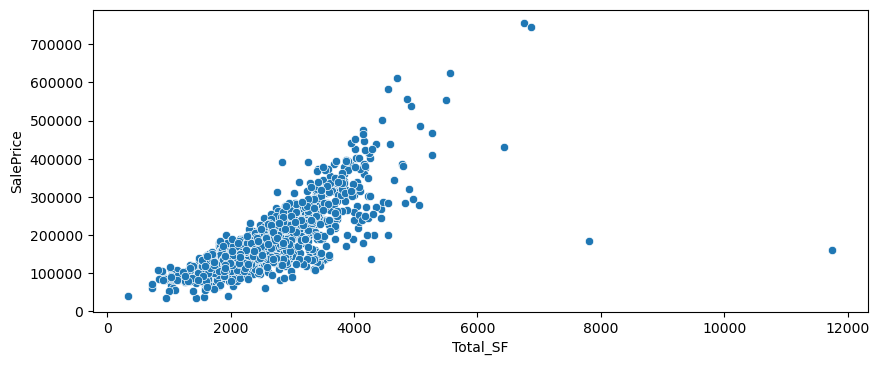

In [17]:
feats_w_target = final_feats.copy()
feats_w_target['SalePrice'] = target
sns.scatterplot(x=feats_w_target.Total_SF, y=feats_w_target.SalePrice)

In [18]:
feats_w_target[(feats_w_target.Total_SF > 7000) & (feats_w_target.SalePrice < 250000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,test_data,Total_Bath,Porch_SF,Total_SF,SalePrice
523,2story 1946+,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,5,3,PConc,5,3,Gd,GLQ,Unf,GasA,5,Y,SBrkr,4676,3,1,5,Typ,1,BuiltIn,2007.0,Fin,3.0,3,3,Y,0,None,0,10,2007,New,Partial,False,4.5,614.0,7814.0,184750.0
1298,2story 1946+,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,3,PConc,5,3,Gd,GLQ,Unf,GasA,5,Y,SBrkr,5642,3,1,5,Typ,3,Attchd,2008.0,Fin,2.0,3,3,Y,480,None,0,1,2008,New,Partial,False,4.5,506.0,11752.0,160000.0


## Scale (standardise) and Transform (normalise) numeric variables

In [20]:
# from src.analyse import analyse
# from src.analyse import test_trans
from src.preprocess import preprocess

scale_feats =  [col for col in final_feats.columns if final_feats.dtypes[col] != "object"]
trans_feats = ['LotArea', 'Total_SF', 'GrLivArea']

final_train = final_feats[final_feats['test_data'] == False]
final_train = final_train.drop([523, 1298]) # Drop two massive outliers, see above
final_test = final_feats[final_feats['test_data'] == True]

final_train, pipelines = preprocess(final_train, scale_list=scale_feats, transform_list=trans_feats)
final_target, _ = preprocess(pd.DataFrame(target), scale_list=['SalePrice'], transform_list=['SalePrice'])
final_target = final_target['SalePrice']
final_target = final_target.drop([523, 1298]) # Drop two massive outliers


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

X_train, X_valid, y_train, y_valid = train_test_split(final_train, final_target, test_size=0.1, random_state=42)

forest = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=42, max_features=0.5, min_samples_leaf=2, max_depth=20)
forest.fit(X_train, y_train)
preds = forest.predict(X_valid)
print(mean_squared_error(y_valid, preds, squared=False))


0.32212540214321667
